(sampling_conjugate_step)=
# Using a custom step method for sampling from locally conjugate posterior distributions

:::{post} Nov 17, 2020
:tags: sampling, step method
:category: advanced
:author: Christopher Krapu
:::

## Introduction

Markov chain Monte Carlo (MCMC) sampling methods are fundamental to modern Bayesian inference. PyMC leverages Hamiltonian Monte Carlo (HMC), a powerful sampling algorithm that efficiently explores high-dimensional posterior distributions. Unlike simpler MCMC methods, HMC harnesses the gradient of the log posterior density to make intelligent proposals, allowing it to effectively sample complex posteriors with hundreds or thousands of parameters. A key advantage of HMC is its generality - it works with arbitrary prior distributions and likelihood functions, without requiring conjugate pairs or closed-form solutions. This is crucial since most real-world models involve priors and likelihoods whose product cannot be analytically integrated to obtain the posterior distribution. HMC's gradient-guided proposals make it dramatically more efficient than earlier MCMC approaches that rely on random walks or simple proposal distributions.

However, these gradient computations can often be expensive for models with especially complicated functional dependencies between variables and observed data. When this is the case, we may wish to find a faster sampling scheme by making use of additional structure in some portions of the model. When a number of variables within the model are *conjugate*, the conditional posterior--that is, the posterior distribution holding all other model variables fixed--can often be sampled from very easily. This suggests using a HMC-within-Gibbs step in which we alternate between using cheap conjugate sampling for variables when possible, and using more expensive HMC for the rest. 

Generally, it is not advisable to pick *any* alternative sampling method and use it to replace HMC. This combination often yields much worse performance in terms of *effective* sampling rates, even if the individual samples are drawn much more rapidly. In this notebook, we show how to implement a conjugate sampling scheme in PyMC and compare it against a full-HMC (or, in this case, NUTS) approach. For this case, we find that using conjugate sampling can dramatically speed up computations for a Dirichlet-multinomial model.

## Probabilistic model

To keep this notebook simple, we'll consider a relatively simple hierarchical model defined for $N$ observations of a vector of counts across $J$ outcomes::

$$\tau \sim Exp(\lambda)$$
$$\mathbf{p}_i \sim Dir(\tau )$$
$$\mathbf{x}_i \sim Multinomial(\mathbf{p}_i)$$

The index $i\in\{1,...,N\}$ represents the observation while $j\in \{1...,J\}$ indexes the outcome. The variable $\tau$ is a scalar concentration while $\mathbf{p}_i$ is a $J$-vector of probabilities drawn from a Dirichlet prior with entries $(\tau, \tau, ..., \tau)$. With fixed $\tau$ and observed data $x$, we know that $\mathbf{p}$ has a [closed-form posterior distribution](https://en.wikipedia.org/wiki/Dirichlet_distribution#Conjugate_to_categorical/multinomial), meaning that we can easily sample from it. Our sampling scheme will alternate between using the No-U-Turn sampler (NUTS) on $\tau$ and drawing from this known conditional posterior distribution for $\mathbf{p}_i$. We will assume a fixed value for $\lambda$.

## Implementing a custom step method

Adding a conjugate sampler as part of our compound sampling approach is straightforward: we define a new step method that examines the current state of the Markov chain approximation and modifies it by adding samples drawn from the conjugate posterior.

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm

from pymc.distributions.transforms import simplex as stick_breaking
from pymc.step_methods.arraystep import BlockedStep

In [2]:
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")

First, we need a method for sampling from a Dirichlet distribution. The built in `numpy.random.dirichlet` can only handle 2D input arrays, and we might like to generalize beyond this in the future. Thus, I have created a function for sampling from a Dirichlet distribution with parameter array `c` by representing it as a normalized sum of Gamma random variables. More detail about this is given [here](https://en.wikipedia.org/wiki/Dirichlet_distribution#Gamma_distribution).

In [3]:
def sample_dirichlet(c):
    """
    Samples Dirichlet random variables which sum to 1 along their last axis.
    """
    gamma = np.random.gamma(c)
    p = gamma / gamma.sum(axis=-1, keepdims=True)
    return p

Next, we define the step object used to replace NUTS for part of the computation. It must have a `step` method that receives a dict called `point` containing the current state of the Markov chain. We'll modify it in place.

There is an extra complication here as PyMC does not track the state of the Dirichlet random variable in the form $\mathbf{p}=(p_1, p_2 ,..., p_J)$ with the constraint $\sum_j p_j = 1$. Rather, it uses an inverse stick breaking transformation of the variable which is easier to use with NUTS. This transformation removes the constraint that all entries must sum to 1 and are positive.

In [4]:
class ConjugateStep(BlockedStep):
    def __init__(self, var, counts: np.ndarray, concentration):
        self.vars = [var]
        self.counts = counts
        self.name = var.name
        self.conc_prior = concentration
        self.shared = {}

    def step(self, point: dict):
        # Since our concentration parameter is going to be log-transformed
        # in point, we invert that transformation so that we
        # can get conc_posterior = conc_prior + counts
        conc_posterior = np.exp(point[self.conc_prior.name + "_log__"]) + self.counts
        draw = sample_dirichlet(conc_posterior)

        # Since our new_p is not in the transformed / unconstrained space,
        # we apply the transformation so that our new value
        # is consistent with PyMC's internal representation of p
        point[self.name] = stick_breaking.forward(draw).eval()

        return point, []  # Return empty stats list as second element

The usage of `point` and its indexing variables can be confusing here. This expression is necessary because when `step` is called, it is passed a dictionary `point` with string variable names as keys. 

However, the prior parameter's name won't be stored directly in the keys for `point` because PyMC stores a transformed variable instead. Thus, we will need to query `point` using the *transformed name* (hence, the `_log__` suffix) and then undo that transformation.

To identify the correct variable to query into `point`, we need to take an argument during initialization that tells the sampling step where to find the prior parameter. Thus, we pass `var` into `ConjugateStep` so that the sampler can find the name of the transformed variable (`var.transformed.name`) later.

## Simulated data

We'll try out the sampler on some simulated data. Fixing $\tau=0.5$, we'll draw 500 observations of a 10 dimensional Dirichlet distribution.

In [5]:
J = 10
N = 500

ncounts = 20
tau_true = 0.5
alpha = tau_true * np.ones([N, J])
p_true = sample_dirichlet(alpha)
counts = np.zeros([N, J])

for i in range(N):
    counts[i] = np.random.multinomial(ncounts, p_true[i])
print(counts.shape)

(500, 10)


## Comparing partial conjugate with full NUTS sampling

We don't have any closed form expression for the posterior distribution of $\tau$ so we will use NUTS on it. In the code cell below, we fit the same model using 1) conjugate sampling on the probability vectors with NUTS on $\tau$, and 2) NUTS for everything.

In [6]:
traces = []
models = []
names = ["Partial conjugate sampling", "Full NUTS"]

for use_conjugate in [True, False]:
    with pm.Model() as model:
        tau = pm.Exponential("tau", lam=1, initval=1.0)
        alpha = pm.Deterministic("alpha", tau * np.ones([N, J]))
        p = pm.Dirichlet("p", a=alpha)

        if use_conjugate:
            # If we use the conjugate sampling, we don't need to define the likelihood
            # as it's already taken into account in our custom step method
            step = [ConjugateStep(model.rvs_to_values[p], counts, tau)]

        else:
            x = pm.Multinomial("x", n=ncounts, p=p, observed=counts)
            step = []

        trace = pm.sample(step=step, chains=1, random_seed=RANDOM_SEED)
        traces.append(trace)

    # assert all(az.summary(trace)["r_hat"] < 1.1)
    models.append(model)

Sequential sampling (1 chains in 1 job)
CompoundStep
>ConjugateStep: [p]
>NUTS: [tau]


Output()

Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 26527 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [tau, p]


Output()

Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 104 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


We see that the runtimes for the partially conjugate sampling are much lower, though this can be misleading if the samples have high autocorrelation or the chains are mixing very slowly. We also see that there are a few divergences in the NUTS-only trace.

We want to make sure that the two samplers are converging to the same estimates. The posterior histogram and trace plot below show that both essentially converge to $\tau$ within reasonable posterior uncertainty credible intervals. We can also see that the trace plots lack any obvious autocorrelation as they are mostly indistinguishable from white noise.

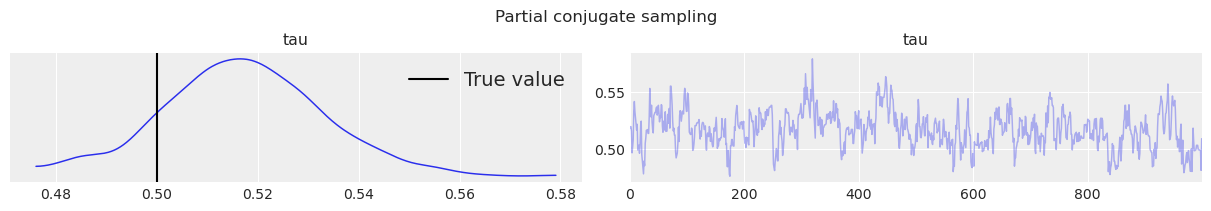

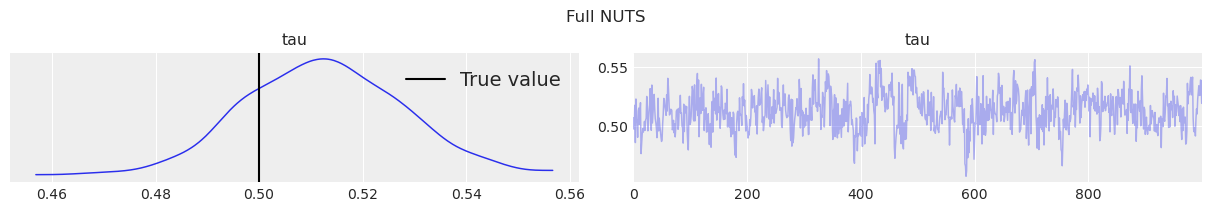

In [7]:
for name, trace in zip(names, traces):
    ax = az.plot_trace(trace, var_names="tau")
    ax[0, 0].axvline(0.5, label="True value", color="k")
    ax[0, 0].legend()
    plt.suptitle(name)

We want to avoid comparing sampler effectiveness in terms of raw samples per second. If a sampler works quickly per sample but generates highly correlated samples, the effective sample size (ESS) is diminished. Since our posterior analyses are critically dependent on the effective sample size, we should examine this latter quantity instead.

This model includes $500\times 10=5000$ probability values for the 500 Dirichlet random variables. Let's calculate the effective sample size for each of these 5000 entries and generate a histogram for each sampling method:

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


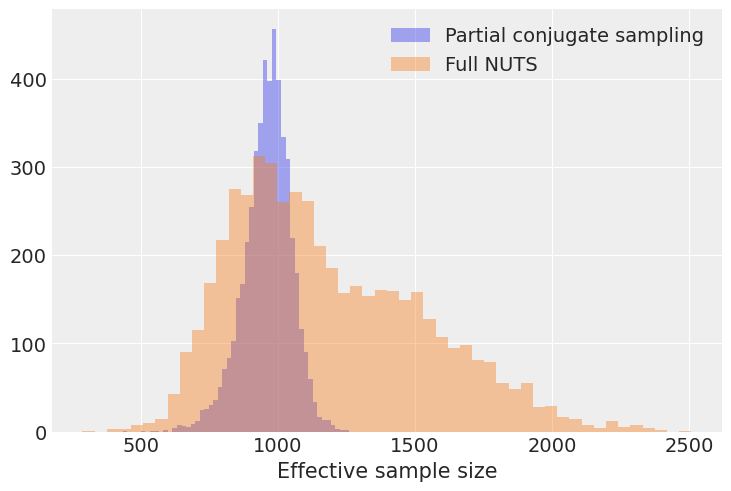

In [8]:
summaries_p = []
for trace, model in zip(traces, models):
    with model:
        summaries_p.append(az.summary(trace, var_names="p"))

[plt.hist(s["ess_bulk"], bins=50, alpha=0.4, label=names[i]) for i, s in enumerate(summaries_p)]
plt.legend(), plt.xlabel("Effective sample size");

Interestingly, we see that while the mode of the ESS histogram is larger for the full NUTS run, the minimum ESS appears to be lower. Since our inferences are often constrained by the of the worst-performing part of the Markov chain, the minimum ESS is of interest.

In [9]:
print("Minimum effective sample sizes across all entries of p:")
print({names[i]: s["ess_bulk"].min() for i, s in enumerate(summaries_p)})

Minimum effective sample sizes across all entries of p:
{'Partial conjugate sampling': 435.0, 'Full NUTS': 288.0}


Here, we can see that the conjugate sampling scheme gets a similar number of effective samples in the worst case. However, there is an enormous  disparity when we consider the effective sampling *rate*.

In [10]:
print("Minimum ESS/second across all entries of p:")
print(
    {
        names[i]: s["ess_bulk"].min() / traces[i].posterior.sampling_time
        for i, s in enumerate(summaries_p)
    }
)

Minimum ESS/second across all entries of p:
{'Partial conjugate sampling': 0.016398236944603167, 'Full NUTS': 2.757810535058409}


The partial conjugate sampling scheme is over 10X faster in terms of worst-case ESS rate!

As a final check, we also want to make sure that the probability estimates are the same for both samplers. In the plot below, we can see that estimates from both the partial conjugate sampling and the full NUTS sampling are very closely correlated with the true values.

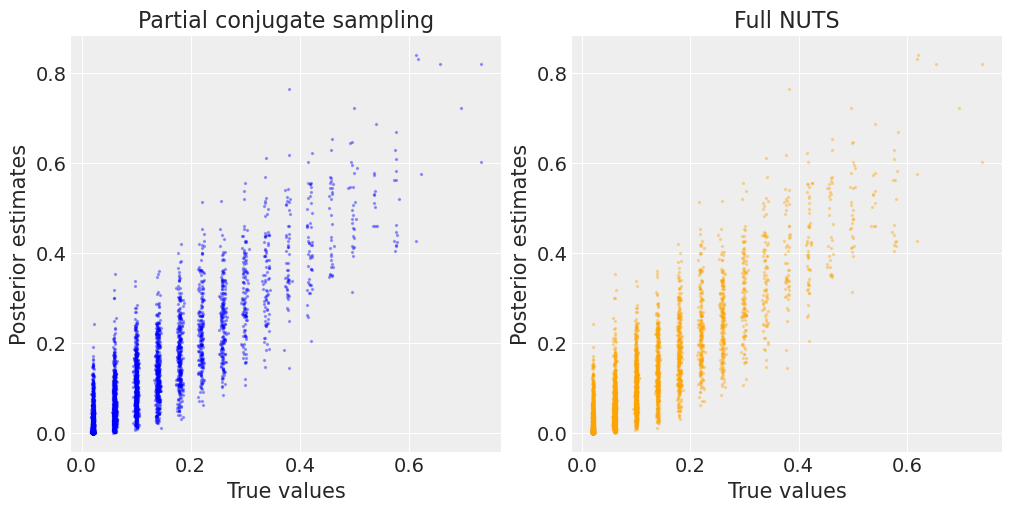

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].scatter(
    summaries_p[0]["mean"],
    p_true.ravel(),
    s=2,
    label="Partial conjugate sampling",
    zorder=2,
    alpha=0.3,
    color="b",
)
axes[0].set_ylabel("Posterior estimates"), axes[0].set_xlabel("True values")

axes[1].scatter(
    summaries_p[1]["mean"],
    p_true.ravel(),
    s=2,
    alpha=0.3,
    color="orange",
)
axes[1].set_ylabel("Posterior estimates"), axes[1].set_xlabel("True values")

[axes[i].set_title(n) for i, n in enumerate(names)];

## Authors

* This notebook was written by Christopher Krapu on November 17, 2020.
* This notebook was updated by Chris Fonnesbeck to use PyMC v5 on December 22, 2024.

In [12]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Sun Dec 22 2024

Python implementation: CPython
Python version       : 3.12.5
IPython version      : 8.27.0

pymc      : 5.19.1
numpy     : 1.26.4
matplotlib: 3.9.2
arviz     : 0.19.0

Watermark: 2.5.0



:::{include} ../page_footer.md
:::